In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow_probability.substrates.jax as tfp

tfd = tfp.distributions
tfb = tfp.bijectors

import jax
from jax.flatten_util import ravel_pytree
import jax.numpy as jnp
import optax

import flax.linen as nn
from flax.core.frozen_dict import freeze, unfreeze

from bijax.advi import ADVI
from bijax.core import transform_dist_params
from bijax.utils import train_fn, initialize_params

from functools import partial
import regdata as rd

init = 123

## Prepare dataset

In [3]:
def load_multinoise(seed):
    N = 100
    key, subkey = jax.random.split(seed)
    X = jax.random.uniform(key, shape=(100, 1), minval=0.0, maxval=0.5).reshape(-1, 1)
    X_test = jax.random.uniform(key, shape=(200, 1), minval=-0.5, maxval=1.0).reshape(-1, 1)
    def f(seed, x):
        epsilons = jax.random.normal(seed, shape=(3,)) * 0.02
        return x + 0.3 * jnp.sin(2 * jnp.pi * (x + epsilons[0])) + 0.3 * jnp.sin(4 * jnp.pi * (x + epsilons[1])) + epsilons[2]
    target_vmap = jax.vmap(f)
    keys = jax.random.split(subkey, X.shape[0])
    y = target_vmap(keys, X)# + jax.random.normal(subkey, shape=(X.shape[0], 1))*0.02
    idx = jnp.argsort(X.ravel())
    return X[idx], y[idx].ravel(), X_test.sort(axis=0)

((100, 1), (100,))

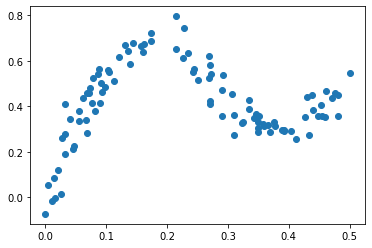

In [4]:
seed = jax.random.PRNGKey(init)
X, y, X_test = load_multinoise(seed)
# X, y, X_test = rd.SineNoisy().get_data()

plt.scatter(X, y);
X.shape, y.shape

## Define and initialize NN

In [5]:
class MLP(nn.Module):
    layers: list
    
    @nn.compact
    def __call__(self, x):
        for num_features in self.layers[:-1]:
            x = nn.relu(nn.Dense(num_features)(x))
        x = nn.Dense(self.layers[-1])(x)
        return x.ravel()

mlp = MLP([16, 1])

## Initialize NN parameters

In [6]:
seed = jax.random.PRNGKey(init+1)
frozen_params = mlp.init(seed, X)

We need to unfreeze the parameters to use outside of `flax`.

In [7]:
init_params = unfreeze(frozen_params)

## Define prior for all NN parameters

Note that `tfd.Independent` will convert all batch dimensions to event dimensions so that each prior distribution can return a scalar log prob.

In [8]:
mlp_prior = jax.tree_map(
    lambda param: tfd.Independent(
#         tfd.Normal(loc=jnp.zeros(param.shape), scale=jnp.sqrt(2*jnp.ones(param.shape)/sum(param.shape))),
        tfd.Normal(loc=jnp.zeros(param.shape), scale=jnp.ones(param.shape)),
        reinterpreted_batch_ndims=len(param.shape),
    ),
    init_params,
)
prior = {"mlp": mlp_prior, "noise_scale": tfd.Gamma(1.0, 2.0)}
prior

{'mlp': {'params': {'Dense_0': {'bias': <tfp.distributions.Independent 'IndependentNormal' batch_shape=[] event_shape=[16] dtype=float32>,
    'kernel': <tfp.distributions.Independent 'IndependentNormal' batch_shape=[] event_shape=[1, 16] dtype=float32>},
   'Dense_1': {'bias': <tfp.distributions.Independent 'IndependentNormal' batch_shape=[] event_shape=[1] dtype=float32>,
    'kernel': <tfp.distributions.Independent 'IndependentNormal' batch_shape=[] event_shape=[16, 1] dtype=float32>}}},
 'noise_scale': <tfp.distributions.Gamma 'Gamma' batch_shape=[] event_shape=[] dtype=float32>}

No change of variable is needed for this model, thus we set `tfd.Identity()` bijector.

In [9]:
mlp_bijector = jax.tree_map(lambda param: tfb.Identity(), init_params)
bijector = {"mlp": mlp_bijector, "noise_scale": tfb.Exp()}
bijector

{'mlp': {'params': {'Dense_0': {'bias': <tfp.bijectors.Identity 'identity' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>,
    'kernel': <tfp.bijectors.Identity 'identity' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>},
   'Dense_1': {'bias': <tfp.bijectors.Identity 'identity' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>,
    'kernel': <tfp.bijectors.Identity 'identity' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>}}},
 'noise_scale': <tfp.bijectors.Exp 'exp' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>}

## Define log likelihood function

In [10]:
def log_likelihood_fn(latent_sample, outputs, inputs, **kwargs):
    scale = latent_sample["noise_scale"]
    y_pred = mlp.apply(latent_sample["mlp"], inputs['X'])
    return tfd.Normal(loc=y_pred, scale=scale).log_prob(outputs).sum()

## Initialize the ADVI model

In [11]:
model = ADVI(prior, bijector, log_likelihood_fn, vi_type="mean_field")

## Initialize the parameters

In [12]:
params = model.init(jax.random.PRNGKey(init + 2))
mean = params["posterior"].mean()
params["posterior"] = tfd.MultivariateNormalDiag(
    loc=mean,
    scale_diag=jax.random.normal(jax.random.PRNGKey(init-1), shape=(len(mean), ))-5,
)

## Fit the model

In [13]:
%%time
tx = optax.adam(learning_rate=0.01)
seed1 = jax.random.PRNGKey(init + 4)
seed2 = jax.random.PRNGKey(init + 5)

loss_fn = partial(model.loss_fn, inputs={"X": X}, outputs=y, full_data_size=len(y), n_samples=100)
results = train_fn(
    loss_fn,
    params,
    n_epochs=1000,
    optimizer=tx,
    seed=seed2,
    return_args={"losses"},
)

CPU times: user 8.04 s, sys: 1.13 s, total: 9.16 s
Wall time: 4.55 s


Check the loss

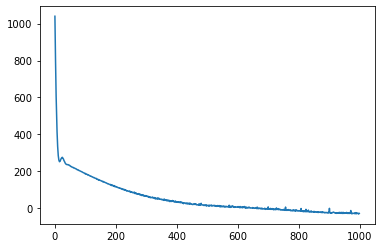

In [14]:
plt.plot(results['losses']);

## Get the posterior distribution

In [15]:
posterior = model.apply(results["params"])

## Draw samples from the posterior

We now generate the samples from the predictive distribution.

In [16]:
seed = jax.random.PRNGKey(init+6)
samples = posterior.sample(seed, sample_shape=(1000,))
def draw_sample(sample):
    y_pred = mlp.apply(sample['mlp'], X_test)
    return y_pred
y_samples = jax.vmap(draw_sample)(samples)
y_samples.shape

(1000, 200)

## Visualizing the fit

0.08503217


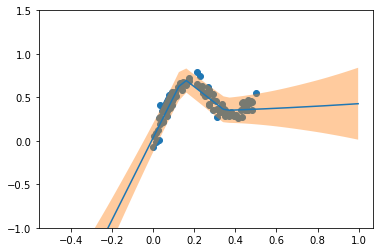

In [17]:
y_mean = y_samples.mean(axis=0)
y_std = y_samples.std(axis=0)

noise_scale = samples['noise_scale'].mean()
print(noise_scale)
plt.scatter(X, y);
plt.plot(X_test, y_mean);
plt.fill_between(X_test.ravel(), y_mean-2*y_std-noise_scale, y_mean+2*y_std+noise_scale, alpha=0.4);
plt.ylim(-1, 1.5);